# Hybrid Images - Noam Isachar

## Part I: Hybrid Images

In [1]:
import cv2

import numpy as np
from matplotlib.colors import LogNorm
from scipy import signal

# modify to where you store your project data including utils.py
datadir = 'input/'

import utils

In [2]:
# switch from notebook to inline if using colab or otherwise cannot use interactive display)
import matplotlib.pyplot as plt
%matplotlib widget  

### Import Images

I took the original images of Derek and Nutmeg and also a pair of my own photos from young and adult age and photos of my girlfriend and cat.
To each pair I added the option to import as greyscale image or in the original colors for the experiment later on.

In [3]:
def read_image(im1_path, im2_path, im1_eyes_points, im2_eyes_points, greyscale=True):
    
    im1_file = datadir + im1_path
    im2_file = datadir + im2_path
    
#     if greyscale:
#         im1 = np.float32(cv2.imread(im1_file, cv2.IMREAD_GRAYSCALE) / 255.0)
#         im2 = np.float32(cv2.imread(im2_file, cv2.IMREAD_GRAYSCALE) / 255.0)
#     else:
#         im1 = np.float32(cv2.imread(im1_file, cv2.IMREAD_COLOR) / 255.0)
#         im2 = np.float32(cv2.imread(im2_file, cv2.IMREAD_COLOR) / 255.0)

#     utils.prompt_eye_selection(im1)
#     plt.plot(im1_eyes_points[:,0], im1_eyes_points[:,1], 'r-+')
#     utils.prompt_eye_selection(im2)
#     plt.plot(im2_eyes_points[:,0], im2_eyes_points[:,1], 'r-+')
    
    im1, im2 = utils.align_images(im1_file, im2_file, im1_eyes_points, im2_eyes_points, save_images=False)
    if greyscale:
        im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
        im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    im1 = im1 / 255.0
    im2 = im2 / 255.0
        
    #Images sanity check
    fig, axes = plt.subplots(1, 2)
    if greyscale:
        axes[0].imshow(im1,cmap='gray')
    else: 
        axes[0].imshow(im1[:,:,::-1])
    axes[0].set_title('Image 1'), axes[0].set_xticks([]), axes[0].set_yticks([])
    if greyscale:
        axes[1].imshow(im2,cmap='gray')
    else: 
        axes[1].imshow(im2[:,:,::-1])
    axes[1].set_title('Image 2'), axes[1].set_xticks([]), axes[1].set_yticks([]);
    
    return im1, im2

In [4]:
def show_im(im, title, greyscale=True, save=False):
    fig = plt.figure()
    if greyscale:
        plt.imshow(im, cmap='gray')
    else:
        plt.imshow(im[:,:,::-1])
    plt.title(title)
    plt.show()
    if save:
        cv2.imwrite('output/' + save, im)

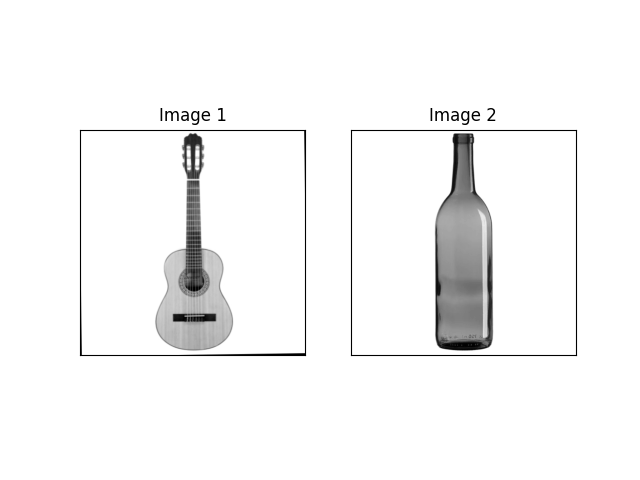

In [5]:
main_im1, main_im2 = read_image('guitar.jpg', 'bottle.jpg', np.array([[215, 249], [285, 250]]), np.array([[215, 250], [285, 250]]), greyscale=True)

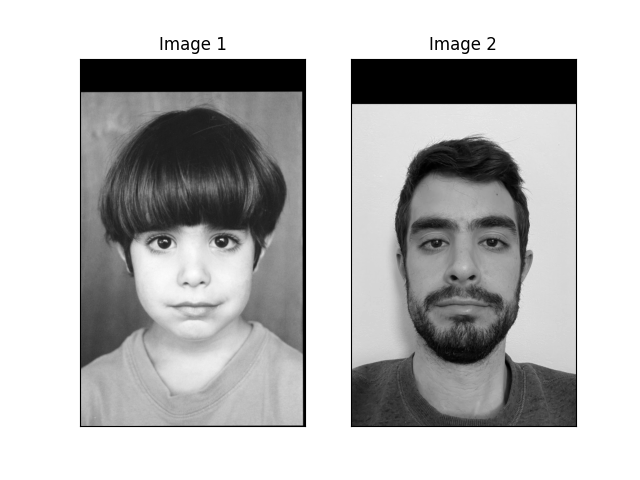

In [6]:
me1_grey, me2_grey = read_image('me1.jpg', 'me2.jpg', np.array([[301, 536], [500, 533]]), np.array([[305, 421], [475, 418]]), greyscale=True)

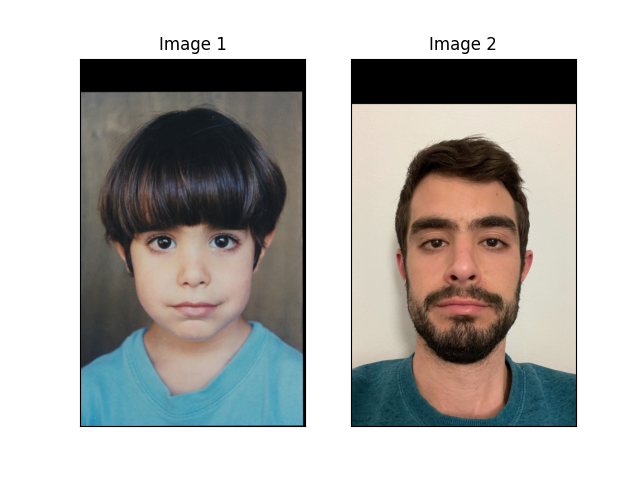

In [7]:
me1_color, me2_color = read_image('me1.jpg', 'me2.jpg', np.array([[301, 536], [500, 533]]), np.array([[305, 421], [475, 418]]), greyscale=False)

### Hybrid Method & Output

Here I implemented the method for outputting a hybrid image. The method supports images to be either greyscale or colored and any combination of the two.
For the filters I used the supplied utils.gaussian_kernel() method with kernel size of 4 times the standard deviation which I found to be a good combination of performance and quality.

The results are below, each one with sigmas I found to look good after experimenting.

In [8]:
def low_pass_filter(im, sigma):
    gaussian_kernel = utils.gaussian_kernel(sigma, int((2 * sigma + 0.5)))
    
    if len(im.shape) == 3 and im.shape[2] == 3:
        filtered_img = np.zeros_like(im)
        for i in range(3):
            filtered_img[...,i] = signal.convolve2d(im[...,i], gaussian_kernel, mode='same')
    
    else:
        filtered_img = signal.convolve2d(im, gaussian_kernel, mode='same')

    return filtered_img


def high_pass_filter(im, sigma):
    low_pass_im = low_pass_filter(im, sigma)
    return im - low_pass_im
    

def hybridImage(im1, im2, sigma_low, sigma_high):
    '''
    Inputs:
        im1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        im2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        sigma_low: standard deviation for the low-pass filter
        sigma_high: standard deviation for the high-pass filter
        
    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    '''  
    if len(im1.shape) != len(im2.shape):
        if len(im1.shape) == 2:
            im1 = np.dstack([im1, im1, im1])
        if len(im2.shape) == 2:
            im2 = np.dstack([im2, im2, im2])
            
    low_pass = low_pass_filter(im1, sigma_low)
    high_pass = high_pass_filter(im2, sigma_high)
    hybrid = low_pass + high_pass
        
    return low_pass, high_pass, hybrid


In [9]:
low_pass_main, high_pass_main, hybrid_main = hybridImage(main_im2, main_im1, 4, 15)

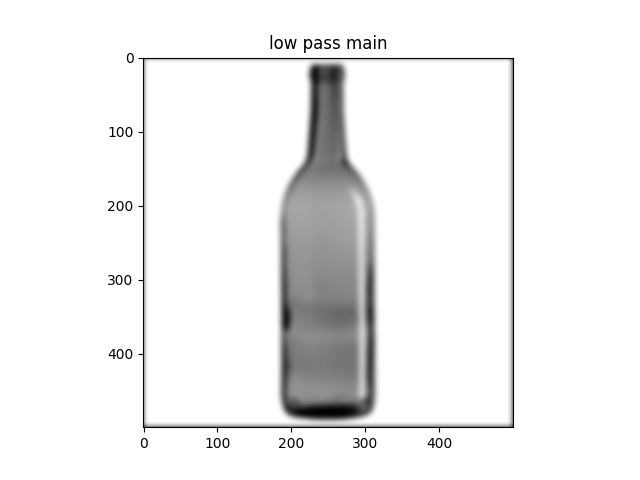

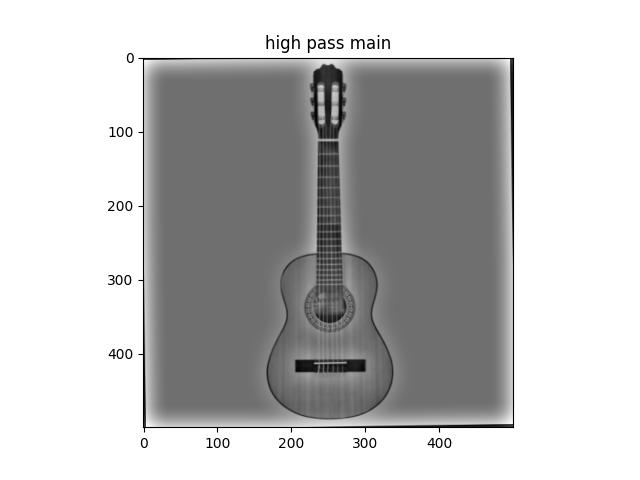

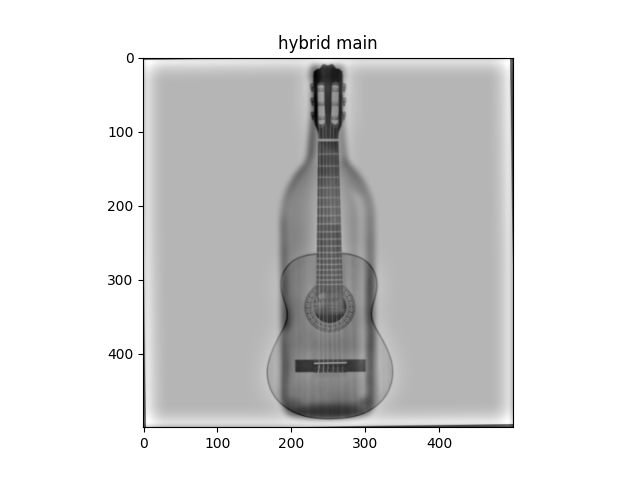

In [10]:
show_im(low_pass_main, 'low pass main')
show_im(high_pass_main, 'high pass main')
show_im(hybrid_main, 'hybrid main')

In [11]:
low_pass_me_grey, high_pass_me_grey, hybrid_me_grey = hybridImage(me2_grey, me1_grey, 15, 10)

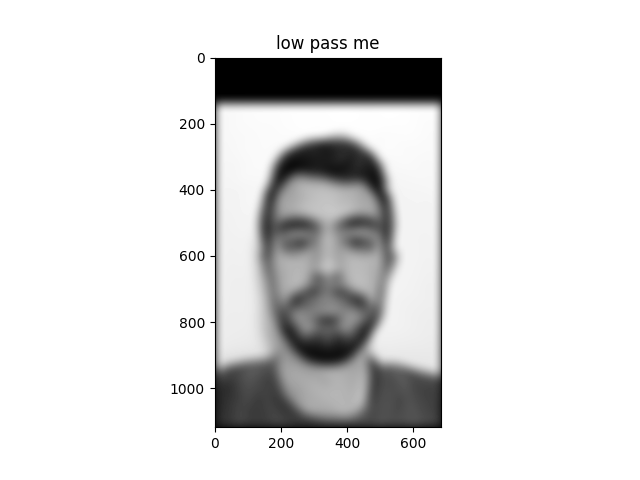

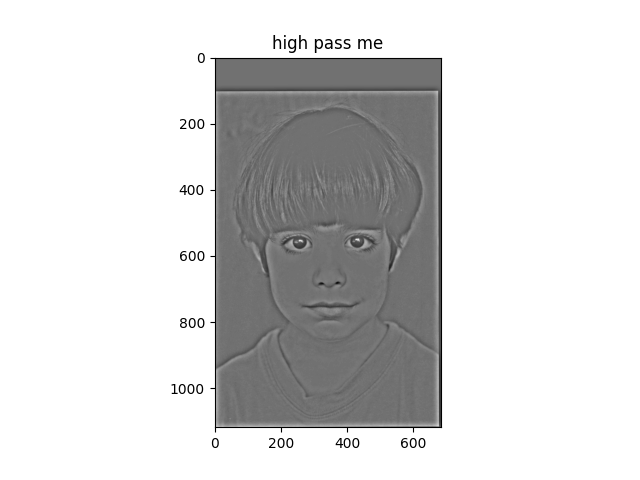

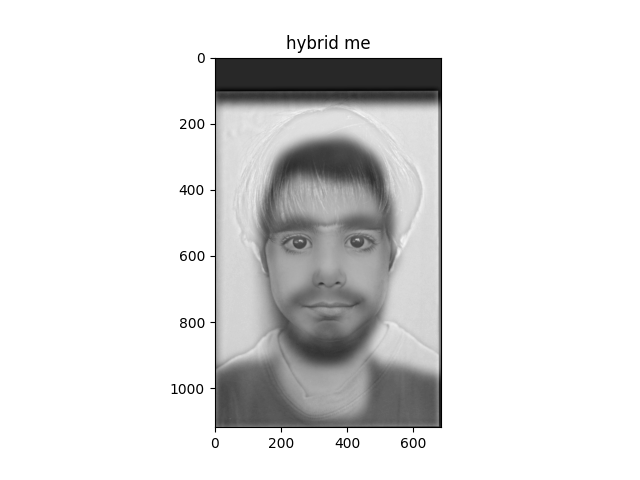

In [12]:
show_im(low_pass_me_grey, 'low pass me')
show_im(high_pass_me_grey, 'high pass me')
show_im(hybrid_me_grey, 'hybrid me')

### Frequency Analysis

Let's look at the FFT of the second example.

In [13]:
def fft(im):
    return np.log(np.abs(np.fft.fftshift(np.fft.fft2(im))))

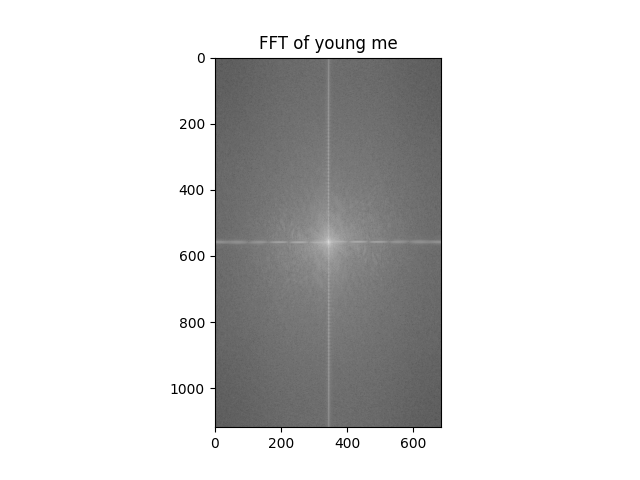

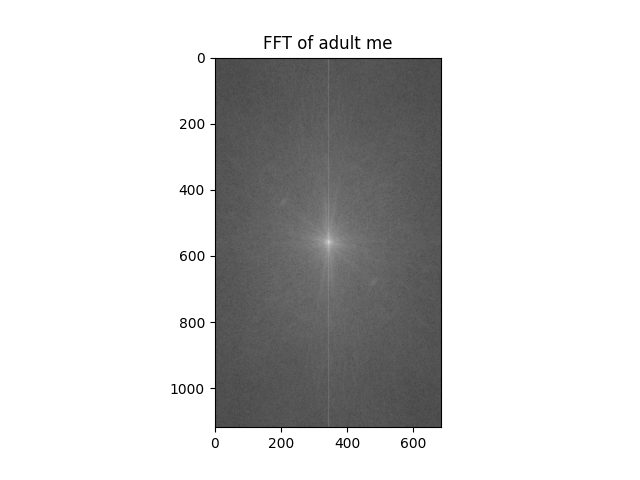

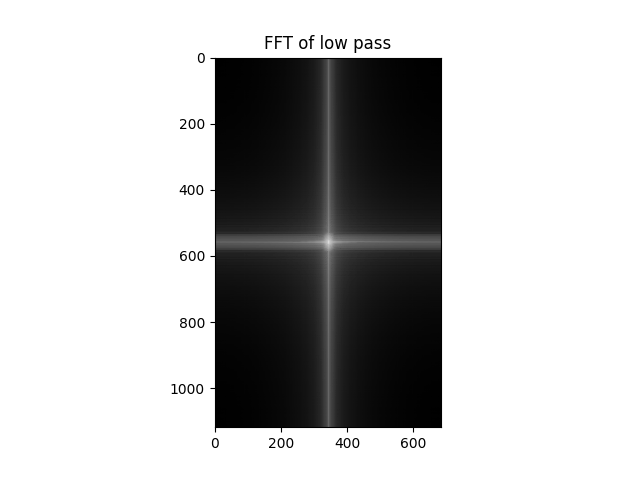

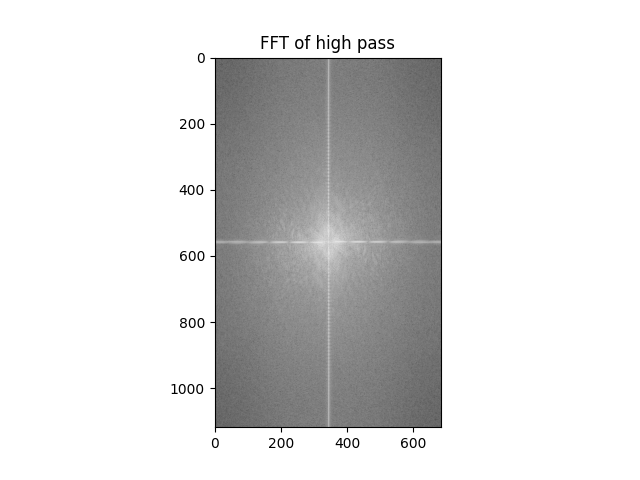

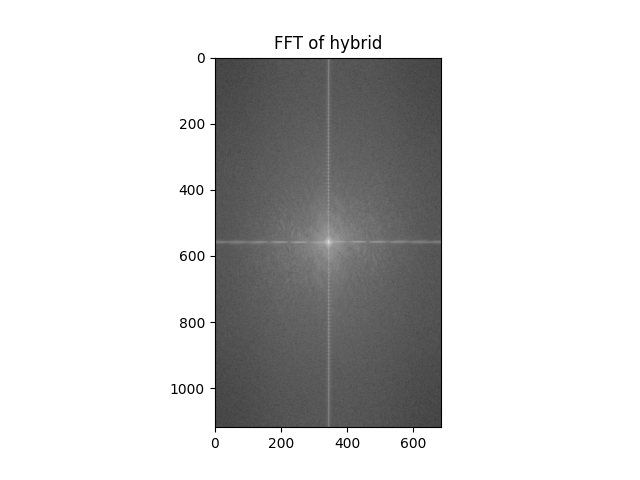

In [14]:
show_im(fft(me1_grey), 'FFT of young me')
show_im(fft(me2_grey), 'FFT of adult me')
show_im(fft(low_pass_me_grey), 'FFT of low pass')
show_im(fft(high_pass_me_grey), 'FFT of high pass')
show_im(fft(hybrid_me_grey), 'FFT of hybrid')

### Color Hybrids

Now let's trying creating hybrids of the second example but with combinations of grey and colored and also of two colored images and then analyze the results.

In [15]:
low_pass_me_color_grey, high_pass_me_color_grey, im_hybrid_me_color_grey = hybridImage(me2_color, me1_grey, 15, 10)
low_pass_me_grey_color, high_pass_me_grey_color, im_hybrid_me_grey_color = hybridImage(me2_grey, me1_color, 15, 10)
low_pass_me_color_color, high_pass_me_color_color, im_hybrid_me_color_color = hybridImage(me2_color, me1_color, 15, 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


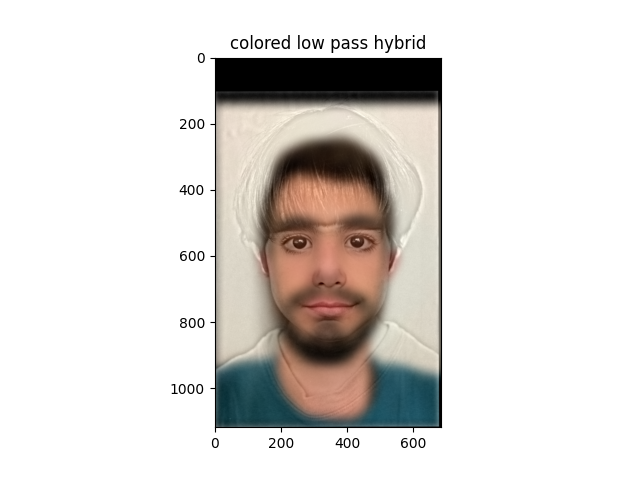

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


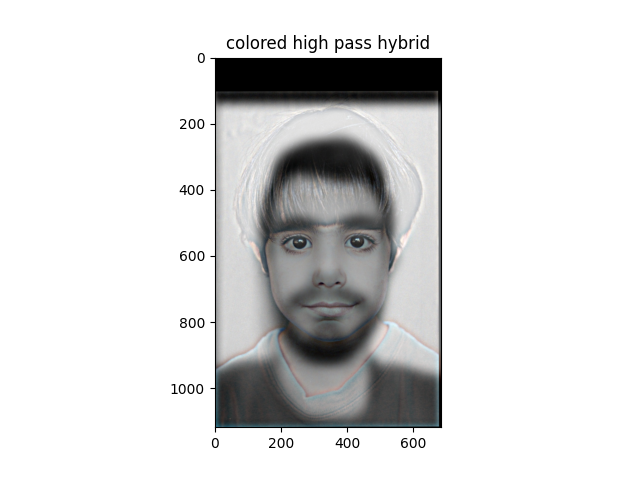

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


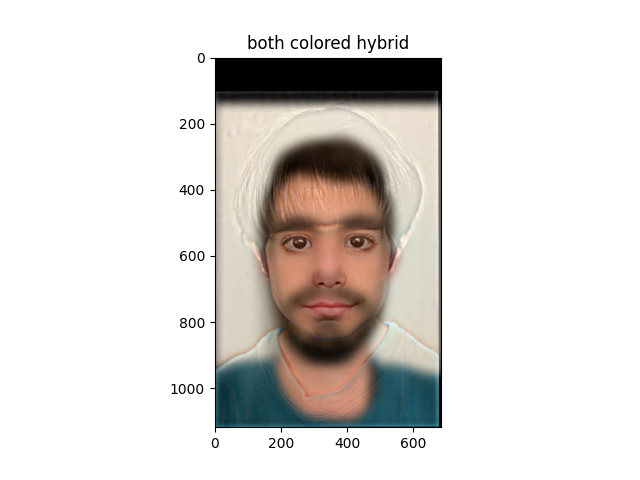

In [16]:
show_im(im_hybrid_me_color_grey, 'colored low pass hybrid', greyscale=False)
show_im(im_hybrid_me_grey_color, 'colored high pass hybrid', greyscale=False)
show_im(im_hybrid_me_color_color, 'both colored hybrid', greyscale=False)

We can see that the low pass filtered i,age must be in color, otherwise the hybrid looks greyscaled. Regarding the high pas filtered image the difference is minor, but since the high pass filter is messing with the colors a bit I would say that the best combination is when the low pass filtered image in colored and the high pass filtered image is greyscaled.

## Part II: Image Enhancement

Two out of three types of image enhancement are required.  Choose a good image to showcase each type and implement a method.  This code doesn't rely on the hybrid image part.

### Contrast enhancement

For this example we will go with the old image of myself, which has poor contrast as it is an old photo.

The method I think is best is gamma correction because it's adjustable and works better than histogram equalization when the background is not very light. We can see that the skin in the gamma correction example looks better.

In [17]:
def contrast_enhancement_hist(im):
    enhanced_im = cv2.equalizeHist(im)
    return enhanced_im

def gamma_correction(im, gamma=1.5):
    lookup_table = np.empty((1, 256), np.uint8)
    for i in range(256):
        lookup_table[0, i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    return cv2.LUT(im, lookup_table)

def contrast_enhancement_gamma(im, gamma=1.5):
    return gamma_correction(im, gamma)

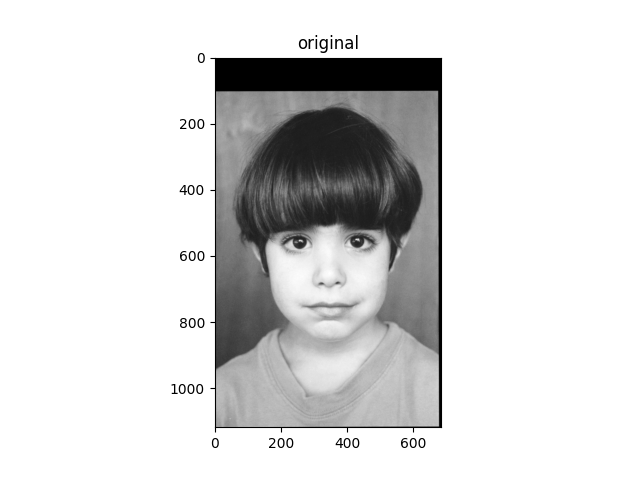

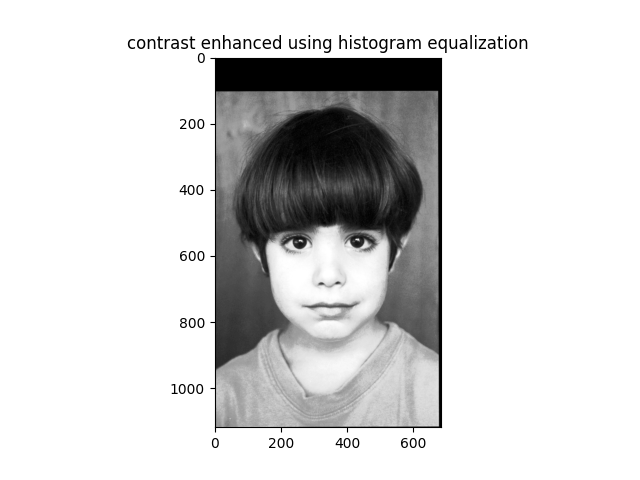

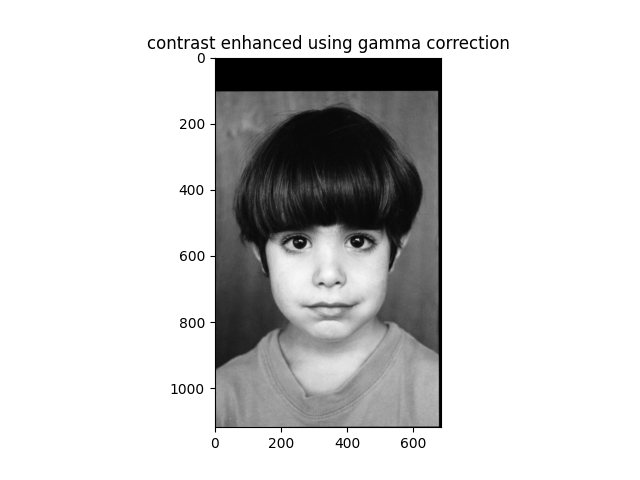

In [18]:
show_im(me1_grey, 'original', greyscale=True)
show_im(contrast_enhancement_hist((me1_grey * 255).astype(np.uint8)), 'contrast enhanced using histogram equalization', greyscale=True)
show_im(contrast_enhancement_gamma((me1_grey * 255).astype(np.uint8), 1.5), 'contrast enhanced using gamma correction', greyscale=True)

### Color enhancement 

Here I also chose my old photo is it could also use some color enhancement.

As instructed, I first convert the image to the HSV color space and then increase the saturation channel by multiplying it by a factor of 1.5 while using np.clip to ensure that the values do not exceed the range of [0, 255]. I chose the 1.5 factor after some experimenting.

In [19]:
def color_enhancement(im, factor=1.5):
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    s = np.uint8(np.clip(s * factor, 0, 255))
    hsv = cv2.merge([h, s, v])
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

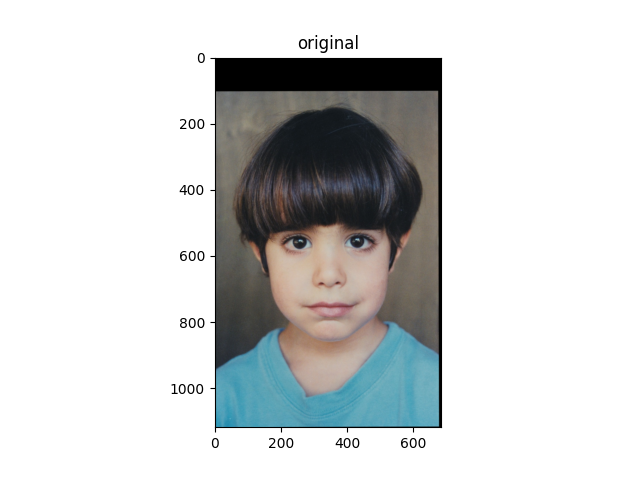

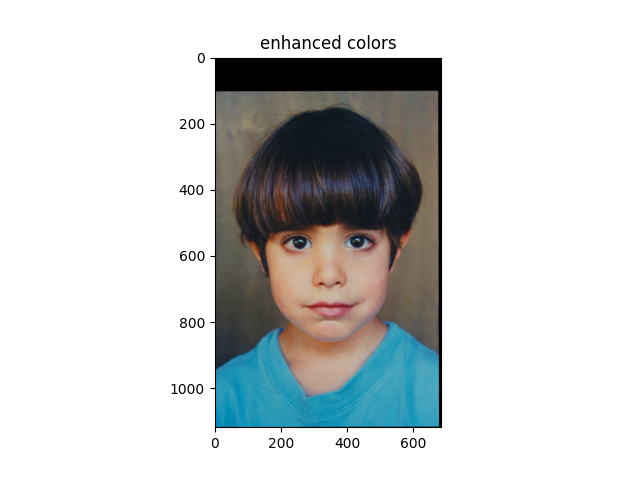

In [20]:
show_im(me1_color, 'original', greyscale=False)
show_im(color_enhancement((me1_color * 255).astype(np.uint8), 1.5), 'enhanced colors', greyscale=False)

### Color shift

For the last image enhancement we have the color shift, and in this case making an image more red or less yellow.

I adopted the suggestion to convert to LAB so I can scale the color on the green-red and blue-yellow scales and get the desired result. I masked the scaling factor to only case where the pixel is more red than green or more yellow than blue and did the appropriate change. I played with they scaling factors a bit until I reached the desired solution.

In [21]:
def more_red(lab):
    l, a, b = cv2.split(lab)
    a = np.where(a>128, a*1.1, a).astype(np.uint8)
    lab = cv2.merge((l, a, b))
    more_red = cv2.cvtColor(lab, cv2.COLOR_Lab2BGR)
    return more_red


def less_yellow(lab):
    l, a, b = cv2.split(lab)
    b = np.where(b>128, b*0.8, b).astype(np.uint8)
    lab = cv2.merge((l, a, b))
    less_yellow = cv2.cvtColor(lab, cv2.COLOR_Lab2BGR)
    return less_yellow
    
    
def color_shift(im):
    lab = cv2.cvtColor(im, cv2.COLOR_BGR2Lab)
    return more_red(lab), less_yellow(lab)

In [22]:
red_and_yellow = cv2.imread(datadir + 'red_and_yellow.jpg')
more_red_im, less_yellow_im = color_shift((red_and_yellow).astype(np.uint8))

C:\Users\nisachar\AppData\Local\Temp\ipykernel_6796\2307068366.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


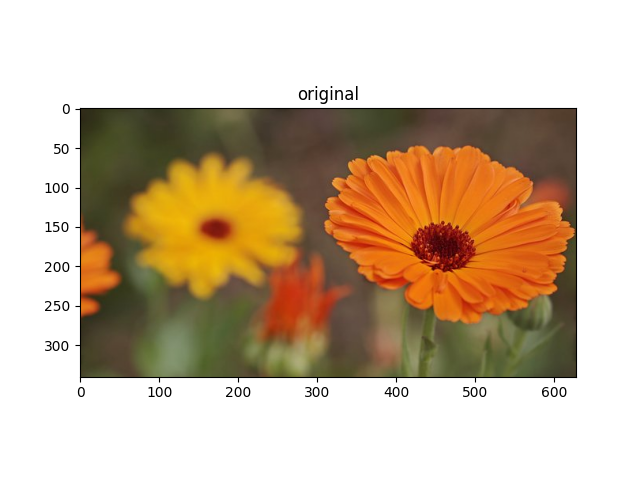

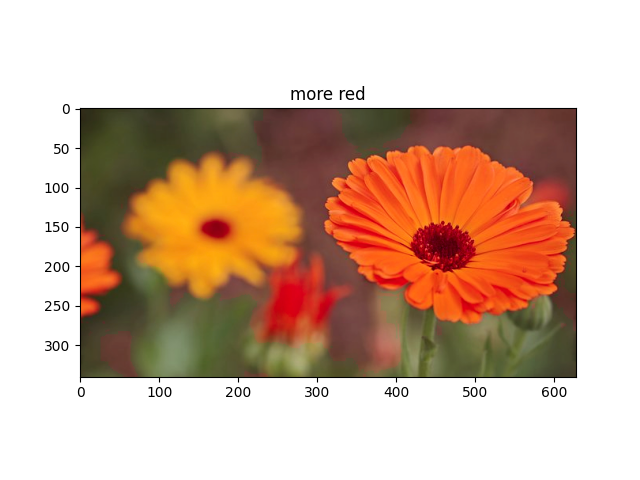

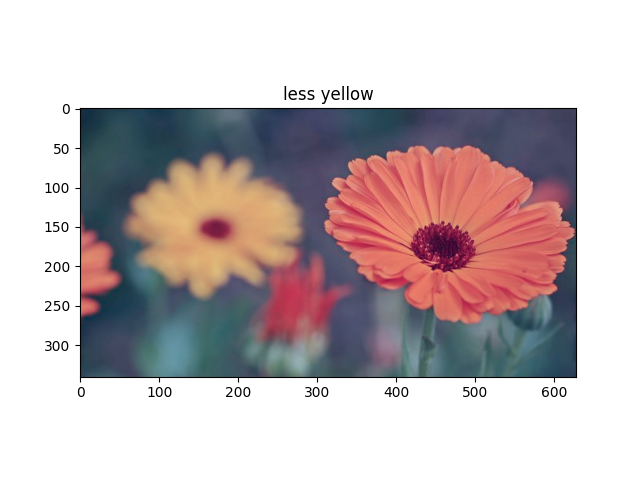

In [23]:
show_im(red_and_yellow, 'original', greyscale=False)
show_im(more_red_im, 'more red', greyscale=False)
show_im(less_yellow_im, 'less yellow', greyscale=False)